# Random Walk - Comparing the prediction capabilities of TD(0) and constant-alpha MC

Ref: RL by Sutton, Barto, Chapter 6, Example 6.2, Pg. 125

# Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym_walk
from collections import defaultdict
from tqdm import tqdm

# Define Functions

## Function: policy

In [2]:
def policy(state, pol_ind):
    if (pol_ind == 1):
        action = np.random.choice([0, 1])
            
    return action

## Function: gen_episode

In [3]:
def gen_episode(env, policy, pol_ind):
    
    '''
    Generate one episode of agent-environment interaction
    Arguments:
        env: Instance of environment to use for generating episode
        policy: Policy to use for generating episode
        pol_ind: Index of policy to use for generating episode        
        
    Returns:
        states_list: List of states encountered in the episode (includes init_state and term_state)
        actions_list: List of actions take by agent at each time step
        rewards_list: List of rewards received by agent at each time step
    '''
    
    states_list = [] # Placeholder to store list of all states encountered in episode
    actions_list = [] # Placeholder to store list of all actions taken by agent
    rewards_list = [] # Placeholder to store list of rewards received at each step

    curr_state = env.reset() # Reset environment and obtain starting state
    while (True): # Run agent till terminal states are reached
        states_list.append(curr_state) # Update states_list with initial state    
        action = policy(curr_state, pol_ind) # Generate action according to current policy
        next_state, rew, done, _ = env.step(action) # Take action and obtain R, S'    
        actions_list.append(action) # Update actions_list
        rewards_list.append(rew) # Update rewards list
        curr_state = next_state
        # Stop episode if terminal state has been reached
        if (done): 
            break
            
    return states_list, actions_list, rewards_list      

## Function: mc_prediction

In [4]:
def mc_prediction(env, policy, pol_ind, num_ep, gamma, visit_type, init_value = 0.0):
    
    '''
    Function to run MC prediction and estimate state value function
    Arguments:
        env: Instance of environment to use for generating episode
        policy: Policy for which SVF has to be estimated
        pol_ind: Index of policy to use for generating episode
        num_ep: Number of episodes to use for MC prediction algorithm
        gamma: Discounting factor for reward computation
        visit_type: 'first' for first-visit MC prediction,
                    'every' for every-visit MC prediction.
        init_value: Value to initialize svf for all states
        
    Returns:
        svf_pi: State value function for policy pi
        state_count: Number of times each state is encountered during MC prediction
    '''
    
    # Initialize value function and count for all states to zero
    svf_pi = defaultdict(lambda: init_value) # State value function for given policy 'pi'
    state_count = defaultdict(int) # Number of times each state is encountered across episodes
    
    # Loop through 'num_ep' episodes
    for ep in range(num_ep):
        ep_states, ep_actions, ep_rewards = gen_episode(env, policy, pol_ind) # Generate one episode
        num_timesteps = len(ep_rewards) # Number of timesteps in current episode
        G = 0 # Initialize return to 0
        
        # Loop through each timestep of current episode
        for ind in range((num_timesteps - 1), -1, -1): 
            G = gamma * G + ep_rewards[ind] # Update return of current timestep
            curr_state = ep_states[ind] # Retrieve state of current timestep
            if (visit_type == 'first'): # For first-visit MC prediction
                if (curr_state not in ep_states[0:ind]):
                    state_count[curr_state] += 1
                    svf_pi[curr_state] += (G - svf_pi[curr_state]) / state_count[curr_state]
            elif (visit_type == 'every'): # For every-visit MC prediction
                state_count[curr_state] += 1
                svf_pi[curr_state] += (G - svf_pi[curr_state]) / state_count[curr_state]
                 
        
    return svf_pi, state_count

## Function: const_alpha_mc_prediction

In [5]:
def const_alpha_mc_prediction(env, policy, pol_ind, num_ep, alpha, gamma = 1.0, visit_type = 'every', init_dict = None):
    
    '''
    Function to run contant-alpha MC prediction and estimate state value function for a given policy
    Arguments:
        env: Instance of environment to use for constant-alpha MC prediction
        policy: Policy to evaluate
        pol_ind: Index of policy to use for generating episode
        num_ep: Number of episodes to use for const-alpha MC prediction algorithm
        alpha: Learning Rate
        gamma: Discounting factor for reward computation
        visit_type: 'first' for first-visit MC prediction,
                    'every' for every-visit MC prediction.
        init_dict: Dictionary based on which svf_pi will be initialized
        
    Returns:
        svf_pi: State-value function for policy pi
    '''
    
    svf_pi = defaultdict(int) # Dictionary to store state value function for given policy 'pi'
    if (init_dict != None):
        if (init_dict['val_init']): 
            for state in init_dict['state_list']:
                svf_pi[state] = init_dict['init_val']
    
    # Loop through 'num_ep' episodes
    for ep in range(num_ep):
        ep_states, ep_actions, ep_rewards = gen_episode(env, policy, pol_ind) # Generate one episode
        num_timesteps = len(ep_rewards) # Number of timesteps in current episode
        G = 0 # Initialize return to 0
        
        # Loop through each timestep of current episode
        for ind in range((num_timesteps - 1), -1, -1): 
            G = gamma * G + ep_rewards[ind] # Update return of current timestep
            curr_state = ep_states[ind] # Retrieve state of current timestep
            if (visit_type == 'first'): # For first-visit MC prediction
                if (curr_state not in ep_states[0:ind]):
                    svf_pi[curr_state] += alpha * (G - svf_pi[curr_state])
            elif (visit_type == 'every'): # For every-visit MC prediction
                svf_pi[curr_state] += alpha * (G - svf_pi[curr_state])
        
    return svf_pi

## Function: td0_prediction

In [6]:
def td0_prediction(env, policy, pol_ind, num_ep, gamma = 1.0, alpha = 0.5, init_dict = None):
    
    """
    Tabular TD(0) algorithm.
    Ref: Section 6.1, Pg. 120 of RL_Sutton
    
    Arguments:
        env: Instance of environment to use for constant-alpha MC prediction
        policy: Policy to evaluate
        pol_ind: Index of policy to use for generating episode
        num_ep: Number of episodes to use for TD(0) prediction algorithm
        gamma: Discounting factor for reward computation
        alpha: Learning Rate       
        init_dict: Dictionary based on which svf_pi will be initialized
        
    Returns:
        svf_pi: State-value function for policy pi    
    
    """
    
    svf_pi = defaultdict(int) # Dictionary to store state value function for given policy 'pi'
    if (init_dict != None):
        if (init_dict['val_init']): 
            for state in init_dict['state_list']:
                svf_pi[state] = init_dict['init_val']

    for ep in range(num_ep): # Iterate through num_ep
        curr_state = env.reset() # Reset environment and obtain starting state
        while (True):
            action = policy(curr_state, pol_ind) # Generate action according to current policy
            next_state, rew, done, _ = env.step(action) # Take action and obtain R, S' 

            # Perform TD(0) update
            td_target = rew + gamma * svf_pi[next_state]
            td_delta = td_target - svf_pi[curr_state]
            svf_pi[curr_state] += alpha * td_delta
            curr_state = next_state # S <-- S'

            if (done):
                break   
    
    return svf_pi

## Function: batch_td0

In [7]:
def batch_td0_prediction(env, policy, pol_ind, num_ep, alpha = 0.5, init_dict = None):
    """
    Function to perform batch TD0-prediction
    Ref: Sec. 6.4, pp. 126 of RL by Sutton, Barto
    
    Arguments:
        env: Instance of environment to use for constant-alpha MC prediction
        policy: Policy to evaluate
        pol_ind: Index of policy to use for generating episode    
        num_ep: Number of episodes over which data will be collected before performing batch update
        alpha: Learning Rate       
        init_dict: Dictionary based on which svf_pi will be initialized        
    """
    
    svf_pi = defaultdict(int) # Dictionary to store state value function for given policy 'pi'
    if (init_dict != None):
        if (init_dict['val_init']): 
            for state in init_dict['state_list']:
                svf_pi[state] = init_dict['init_val'] 
    
    # Generate complete trajectories for the entire episode.
    states_trajectory = [] # Placeholder to store state trajectories of each episode
    actions_trajectory = [] # Placeholder to store action trajectories of each episode
    rewards_trajectory = [] # Placeholder to store reward trajectories of each episode
    
    for ep in range(num_ep): # Loop through 'num_ep' episodes
        states_list, actions_list, rewards_list = gen_episode(env, policy, 1) # Run one episode
        # Update state, action and reward trajectories
        states_trajectory.append(states_list) 
        actions_trajectory.append(actions_list)
        rewards_trajectory.append(rewards_list)

    # Generate cumulative updates
    updates = np.zeros(7) # Placeholder to store cumulative updates
    while(True): # Loop until value converges
        for state_traj, rew_traj in zip(states_trajectory, rewards_trajectory):
            for ind, state in enumerate(state_traj):
                # Get update for current state
                if (ind == (len(state_traj) -1)): # Update for last non-terminal state
                    updates[state] += rew_traj[ind] - svf_pi[state]
                else: # Update for other states
                    updates[state] += rew_traj[ind] + svf_pi[state_traj[ind + 1]]- svf_pi[state]            
        updates *= alpha
        if np.sum(np.abs(updates)) < 1e-3:
            break

        # Perform batch update
        for ind in range(7):
            svf_pi[ind] += updates[ind]

    #svf_pi = np.array(sorted(list(svf_pi.values()))) # Convert svf to array
    return svf_pi

## Function: batch_MC

In [8]:
def batch_mc_prediction(env, policy, pol_ind, num_ep, alpha = 0.5, init_dict = None):
    """
    Function to perform batch MC-prediction
    Ref: Sec. 6.4, pp. 126 of RL by Sutton, Barto
    
    Arguments:
        env: Instance of environment to use for constant-alpha MC prediction
        policy: Policy to evaluate
        pol_ind: Index of policy to use for generating episode    
        num_ep: Number of episodes over which data will be collected before performing batch update
        alpha: Learning Rate       
        init_dict: Dictionary based on which svf_pi will be initialized        
    """
    
    svf_pi = defaultdict(int) # Dictionary to store state value function for given policy 'pi'
    if (init_dict != None):
        if (init_dict['val_init']): 
            for state in init_dict['state_list']:
                svf_pi[state] = init_dict['init_val'] 
    
    # Generate complete trajectories for the entire episode.
    states_trajectory = [] # Placeholder to store state trajectories of each episode
    actions_trajectory = [] # Placeholder to store action trajectories of each episode
    rewards_trajectory = [] # Placeholder to store reward trajectories of each episode
    returns_trajectory = [] # Placeholder to store returns trajectories of each episode
    
    for ep in range(num_ep): # Loop through 'num_ep' episodes
        states_list, actions_list, rewards_list = gen_episode(env, policy, 1) # Run one episode
        returns_list = [rewards_list[-1] for _ in rewards_list]
        # Update state, action and reward trajectories
        states_trajectory.append(states_list) 
        actions_trajectory.append(actions_list)
        rewards_trajectory.append(rewards_list)
        returns_trajectory.append(returns_list)

    # Generate cumulative updates
    updates = np.zeros(7) # Placeholder to store cumulative updates
    while(True): # Loop until value converges
        for state_traj, ret_traj in zip(states_trajectory, returns_trajectory):
            for ind, state in enumerate(state_traj):
                updates[state] += ret_traj[ind] - svf_pi[state] # Get update for current state
        updates *= alpha
        if np.sum(np.abs(updates)) < 1e-3:
            break

        # Perform batch update
        for ind in range(7):
            svf_pi[ind] += updates[ind]

    return svf_pi


# Batch Updates

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [03:38<00:00,  4.28s/it]


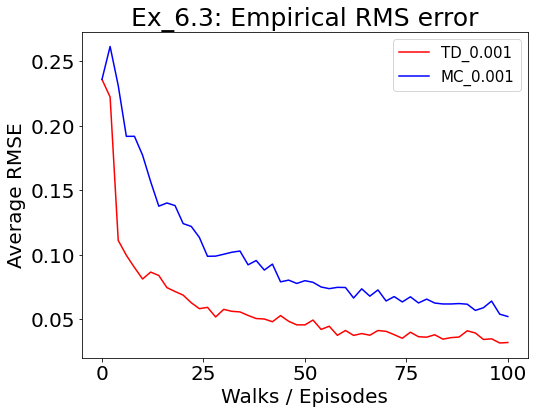

In [9]:
# Instantiate Environment
env = gym.make('WalkFive-v0')

num_states = 7 # Number of states in random walk (2 terminal states)
num_runs = 100 # Number of runs to average over
ep_max = 101
ep_step = 2
alpha = 0.001

# Define true value function
tvf = (1/6) * np.arange(1, 6, 1)

# Dictionary to initialize svf
init_dict = {"val_init": True,
             "state_list": [1, 2, 3, 4, 5],
             "init_val": 0.5
            }

plt.figure(figsize = (8, 6))
plt.title("Ex_6.3: Empirical RMS error", fontsize = 25)
plt.xlabel("Walks / Episodes", fontsize = 20)
plt.ylabel("Average RMSE", fontsize = 20)
plt.xticks(ticks = [0, 25, 50, 75, 100], fontsize = 20)
plt.yticks(ticks = [0, 0.05, 0.1, 0.15, 0.2, 0.25], fontsize = 20)

rmse_td_array = [] # Placeholder to store average rmse for different episode lengths
num_ep_array = [] # Placeholder to store  episode lengths
for num_ep in tqdm(range(0, ep_max, ep_step)): # Loop through different episode lengths
    rmse_td = 0
    for run in range(num_runs): # Iterate through num_runs
        # Run Batch TD(0) algorithm        
        svf_td = batch_td0_prediction(env, policy, 1, num_ep, alpha = 0.001, init_dict = init_dict)        
        if (0 in svf_td.keys()):
            del svf_td[0]
        if (6 in svf_td.keys()):
            del svf_td[6]   
        svf_td = np.array(sorted(list(svf_td.values()))) # Convert svf to array
        rmse_td += np.sqrt(np.mean((tvf - svf_td) ** 2)) # Update rmse with current run
    rmse_td /= num_runs # Average rmse over all runs
    rmse_td_array.append(rmse_td)
    num_ep_array.append(num_ep)
plt.plot(num_ep_array, rmse_td_array, label = ('TD_' + str(alpha)), color = 'r')

rmse_mc_array = [] # Placeholder to store average rmse for different episode lengths
num_ep_array = [] # Placeholder to store  episode lengths
for num_ep in tqdm(range(0, ep_max, ep_step)): # Loop through different episode lengths
    rmse_mc = 0
    for run in range(num_runs): # Iterate through num_runs
        # Run Batch MC algorithm        
        svf_mc = batch_mc_prediction(env, policy, 1, num_ep, alpha = 0.001, init_dict = init_dict) 
        if (0 in svf_mc.keys()):
            del svf_mc[0]
        if (6 in svf_mc.keys()):
            del svf_mc[6]   
        svf_mc = np.array(sorted(list(svf_mc.values()))) # Convert svf to array
        rmse_mc += np.sqrt(np.mean((tvf - svf_mc) ** 2)) # Update rmse with current run
    rmse_mc /= num_runs # Average rmse over all runs
    rmse_mc_array.append(rmse_mc)
    num_ep_array.append(num_ep)
plt.plot(num_ep_array, rmse_mc_array, label = ('MC_' + str(alpha)), color = 'b')

plt.legend(fontsize = 15)
plt.show()